# Test Corr Models

In [97]:
import numpy as np
import pandas as pd
from copy import deepcopy

import correlation_models as CM
import backtesting as BT
import plots as IP
import data_download as dd

### Data 

In [98]:
# Define shares directly (tickers inferred from index)
shares = pd.Series({
    "AAPL": 10,
    "MSFT": 9,
    "NVDA": 80,
    "GOOGL": 6,
    "JPM": -9
})

# Download prices for the tickers in 'shares'
tickers = shares.index.tolist()
prices = dd.get_raw_prices(tickers, start="2024-01-01")

# Convert prices to base currency (e.g. CHF)
prices_converted = dd.convert_to_base(prices, base="CHF")

# Create portfolio with monetary positions
x_matrix = dd.create_portfolio(prices_converted, shares)

# Compute returns and summary stats
returns, mean_returns, covariance_matrix = dd.summary_statistics(x_matrix)

# Display
final_value = x_matrix.sum(axis=1).iloc[-1]
print(f"\nPortfolio final value in CHF: {final_value:.2f}")
print("\nSample of daily returns:\n", returns.head())
print("\nMean returns (daily, in CHF):\n", mean_returns)
print("\nCovariance matrix (in CHF):\n", covariance_matrix)


[currency detection] AAPL: USD
[currency detection] GOOGL: USD
[currency detection] JPM: USD
[currency detection] MSFT: USD
[currency detection] NVDA: USD
[fx download] Downloading FX pairs: CHFUSD=X
[conversion] AAPL: USD → CHF via CHFUSD=X
[conversion] GOOGL: USD → CHF via CHFUSD=X
[conversion] JPM: USD → CHF via CHFUSD=X
[conversion] MSFT: USD → CHF via CHFUSD=X
[conversion] NVDA: USD → CHF via CHFUSD=X

Portfolio final value in CHF: 13083.53

Sample of daily returns:
                 AAPL     GOOGL       JPM      MSFT      NVDA
Date                                                        
2024-01-03  0.002215  0.015257  0.005375  0.009041 -0.002782
2024-01-04 -0.014117 -0.019621  0.005192 -0.008602  0.007570
2024-01-05 -0.002723 -0.003550  0.006319  0.000779  0.024222
2024-01-08  0.025054  0.023792 -0.000594  0.019746  0.065195
2024-01-09 -0.005582  0.011820 -0.011206 -0.000401  0.013592

Mean returns (daily, in CHF):
 AAPL     0.000575
GOOGL    0.000743
JPM      0.001519
MSFT     0

In [99]:
x_matrix.head()

,AAPL,GOOGL,JPM,MSFT,NVDA
Date,,,,,
2024-01-02,1551.522630,694.622688,-1259.144120,2778.545632,3242.954747
2024-01-03,1554.959016,705.220497,-1265.911507,2803.665424,3233.934430
2024-01-04,1533.007736,691.383402,-1272.483602,2779.547063,3258.416930
2024-01-05,1528.834091,688.929295,-1280.525050,2781.711805,3337.342789
2024-01-08,1567.138256,705.320088,-1279.764691,2836.640769,3554.920808


In [100]:
missing_values = x_matrix.isnull().any().any()
print(f"Does x_matrix have missing values? {missing_values}")

Does x_matrix have missing values? False


In [101]:
# Run MA Correlation VaR
x_ma = deepcopy(x_matrix)
result_ma= CM.var_correlation_ma_empirical(x_ma)

# Run RiskMetrics Correlation VaR
x_rm = deepcopy(x_matrix)
result_rm = CM.var_correlation_ewma_empirical(x_rm)


In [102]:
result_ma.head()

,Returns,Volatility,Innovations,VaR,VaR Monetary,VaR Violation
2024-01-31,-0.028007,0.016490,-1.698481,0.041689,344.961154,False
2024-02-01,0.022534,0.016672,1.351645,0.042150,356.650282,False
2024-02-02,0.025885,0.016721,1.548032,0.042274,366.809717,False
2024-02-05,0.034857,0.017601,1.980342,0.044500,399.287666,False
2024-02-06,-0.003063,0.015741,-0.194579,0.039797,355.965608,False


In [103]:
result_rm.head()

,Returns,Volatility,Innovations,VaR,VaR Monetary,VaR Violation
2024-01-03,0.003378,0.022958,0.147125,0.052359,368.178844,False
2024-01-04,-0.005874,0.022446,-0.261675,0.051192,357.827059,False
2024-01-05,0.009680,0.022019,0.439606,0.050218,354.355599,False
2024-01-08,0.046664,0.024316,1.919095,0.055455,409.497480,False
2024-01-09,0.008295,0.023691,0.350108,0.054032,402.284479,False


In [104]:
# Apply volatility-based ES to the MA VaR result
result_ma = CM.es_correlation(result_ma, confidence_level=0.99)

# Same for RiskMetrics
result_rm = CM.es_correlation(result_rm, confidence_level=0.99)

In [105]:
result_ma.head()

,Returns,Volatility,Innovations,VaR,VaR Monetary,VaR Violation,ES,ES Monetary
2024-01-31,-0.028007,0.016490,-1.698481,0.041689,344.961154,False,0.047115,389.858594
2024-02-01,0.022534,0.016672,1.351645,0.042150,356.650282,False,0.047636,403.069086
2024-02-02,0.025885,0.016721,1.548032,0.042274,366.809717,False,0.047776,414.550794
2024-02-05,0.034857,0.017601,1.980342,0.044500,399.287666,False,0.050292,451.255818
2024-02-06,-0.003063,0.015741,-0.194579,0.039797,355.965608,False,0.044977,402.295301


In [106]:
result_rm.head()

,Returns,Volatility,Innovations,VaR,VaR Monetary,VaR Violation,ES,ES Monetary
2024-01-03,0.003378,0.022958,0.147125,0.052359,368.178844,False,0.060498,425.416188
2024-01-04,-0.005874,0.022446,-0.261675,0.051192,357.827059,False,0.059151,413.455107
2024-01-05,0.009680,0.022019,0.439606,0.050218,354.355599,False,0.058025,409.443971
2024-01-08,0.046664,0.024316,1.919095,0.055455,409.497480,False,0.064077,473.158248
2024-01-09,0.008295,0.023691,0.350108,0.054032,402.284479,False,0.062431,464.823908



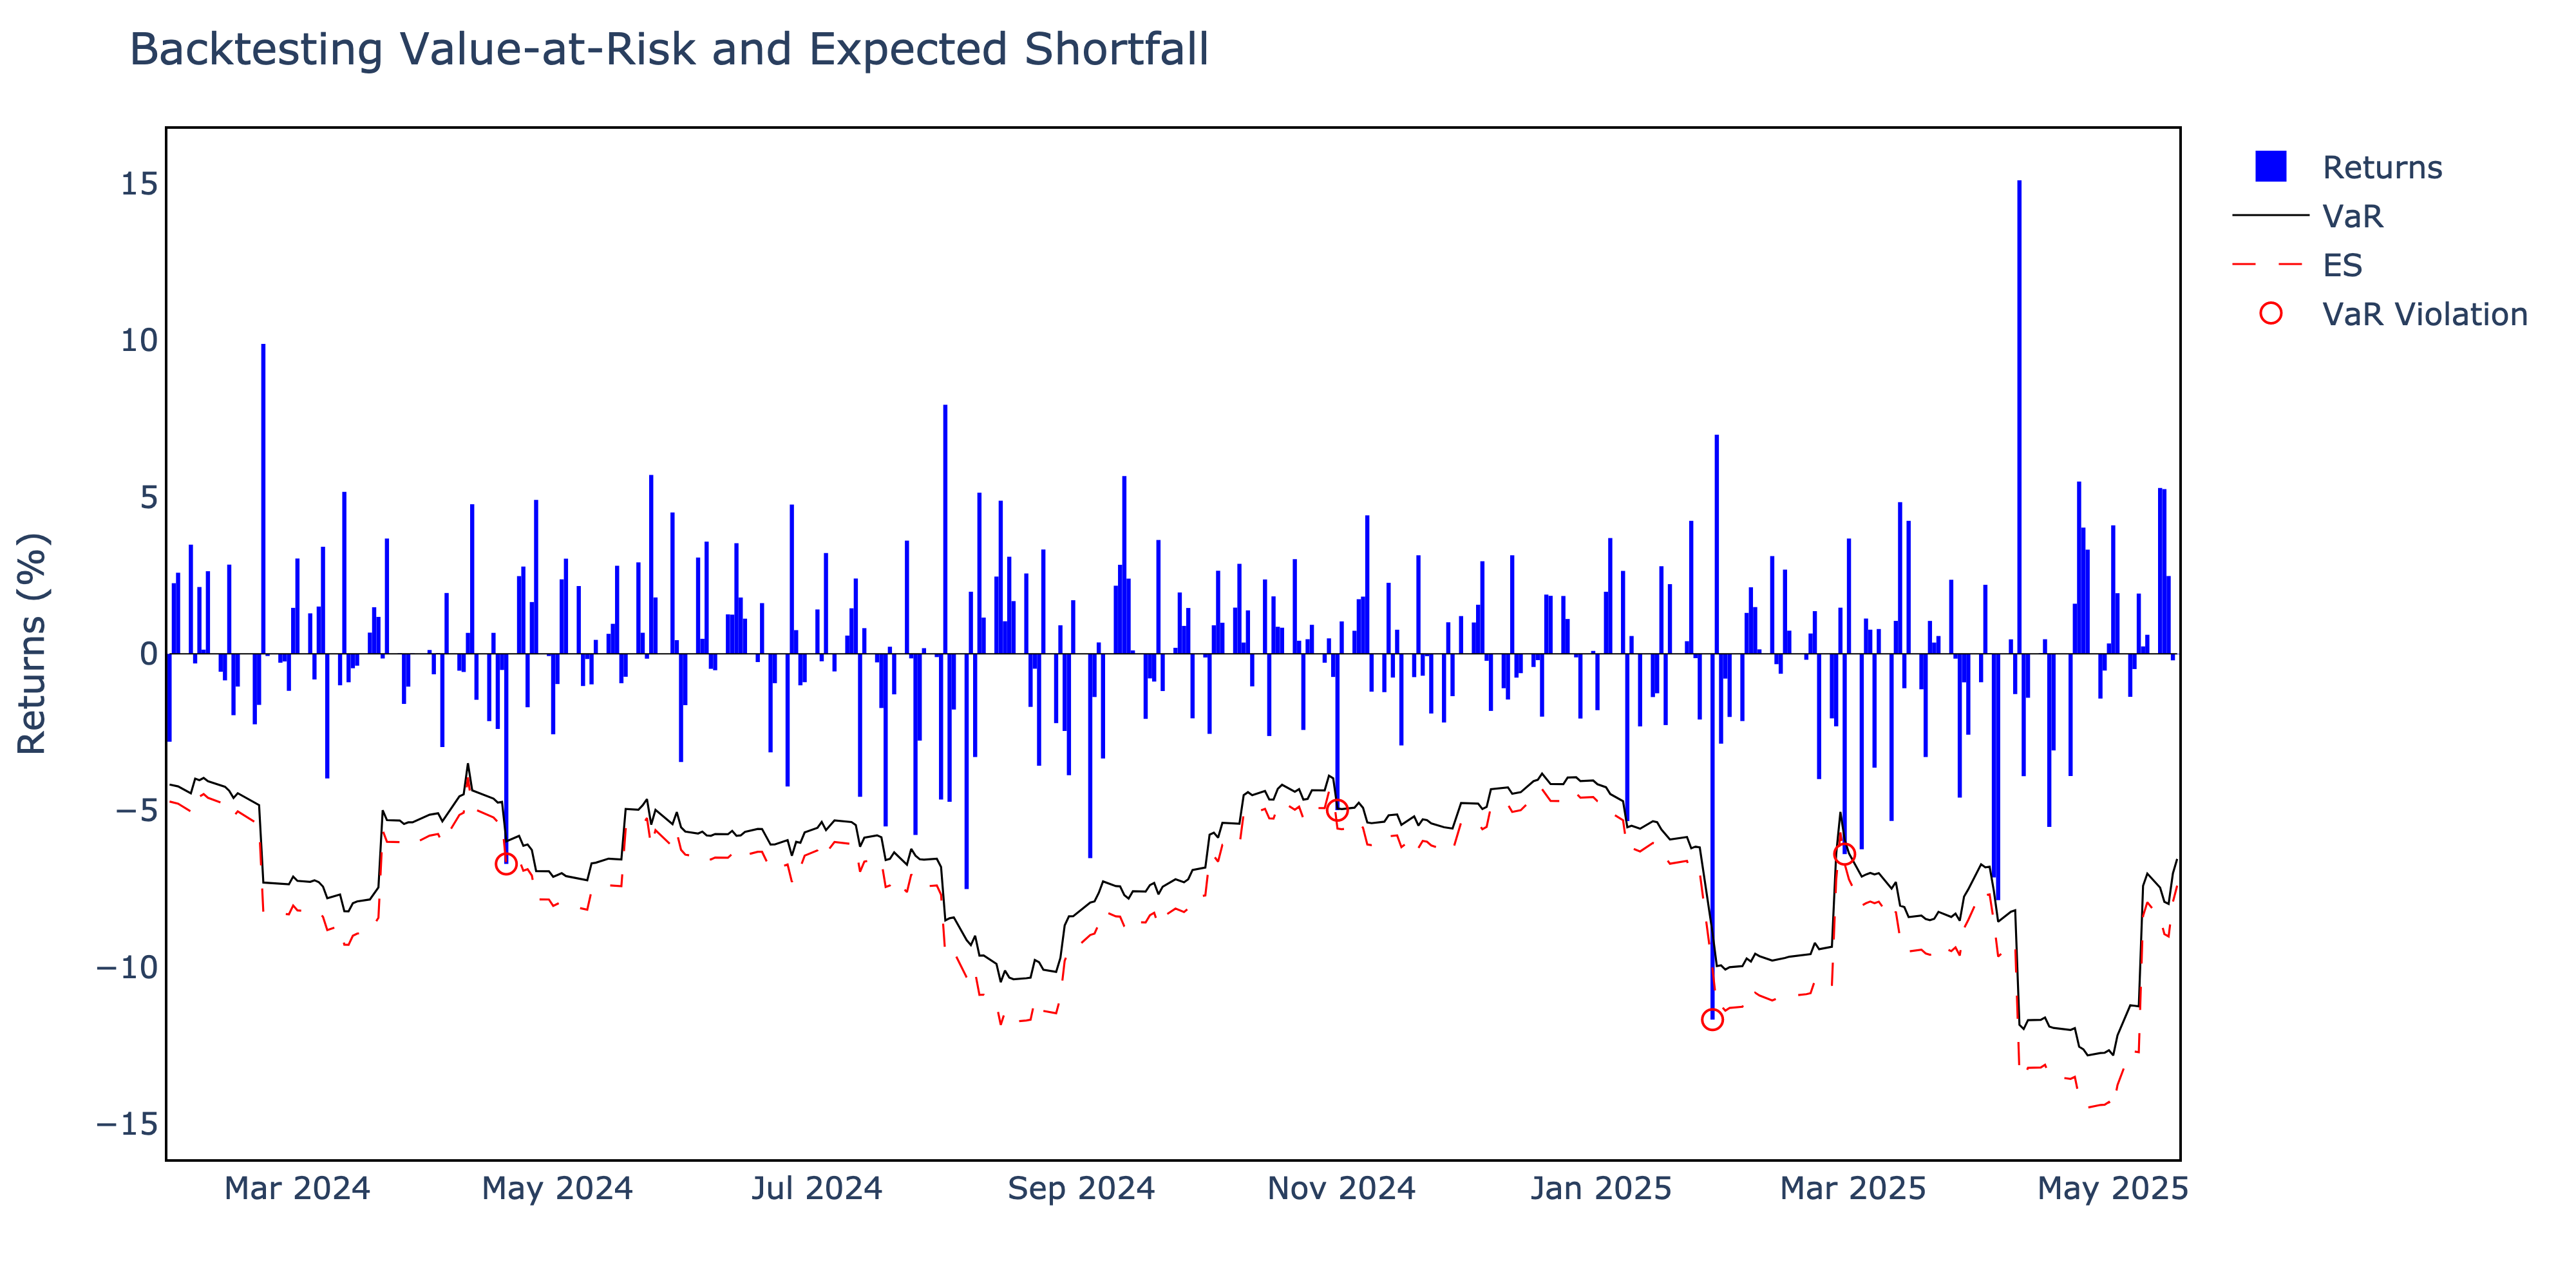


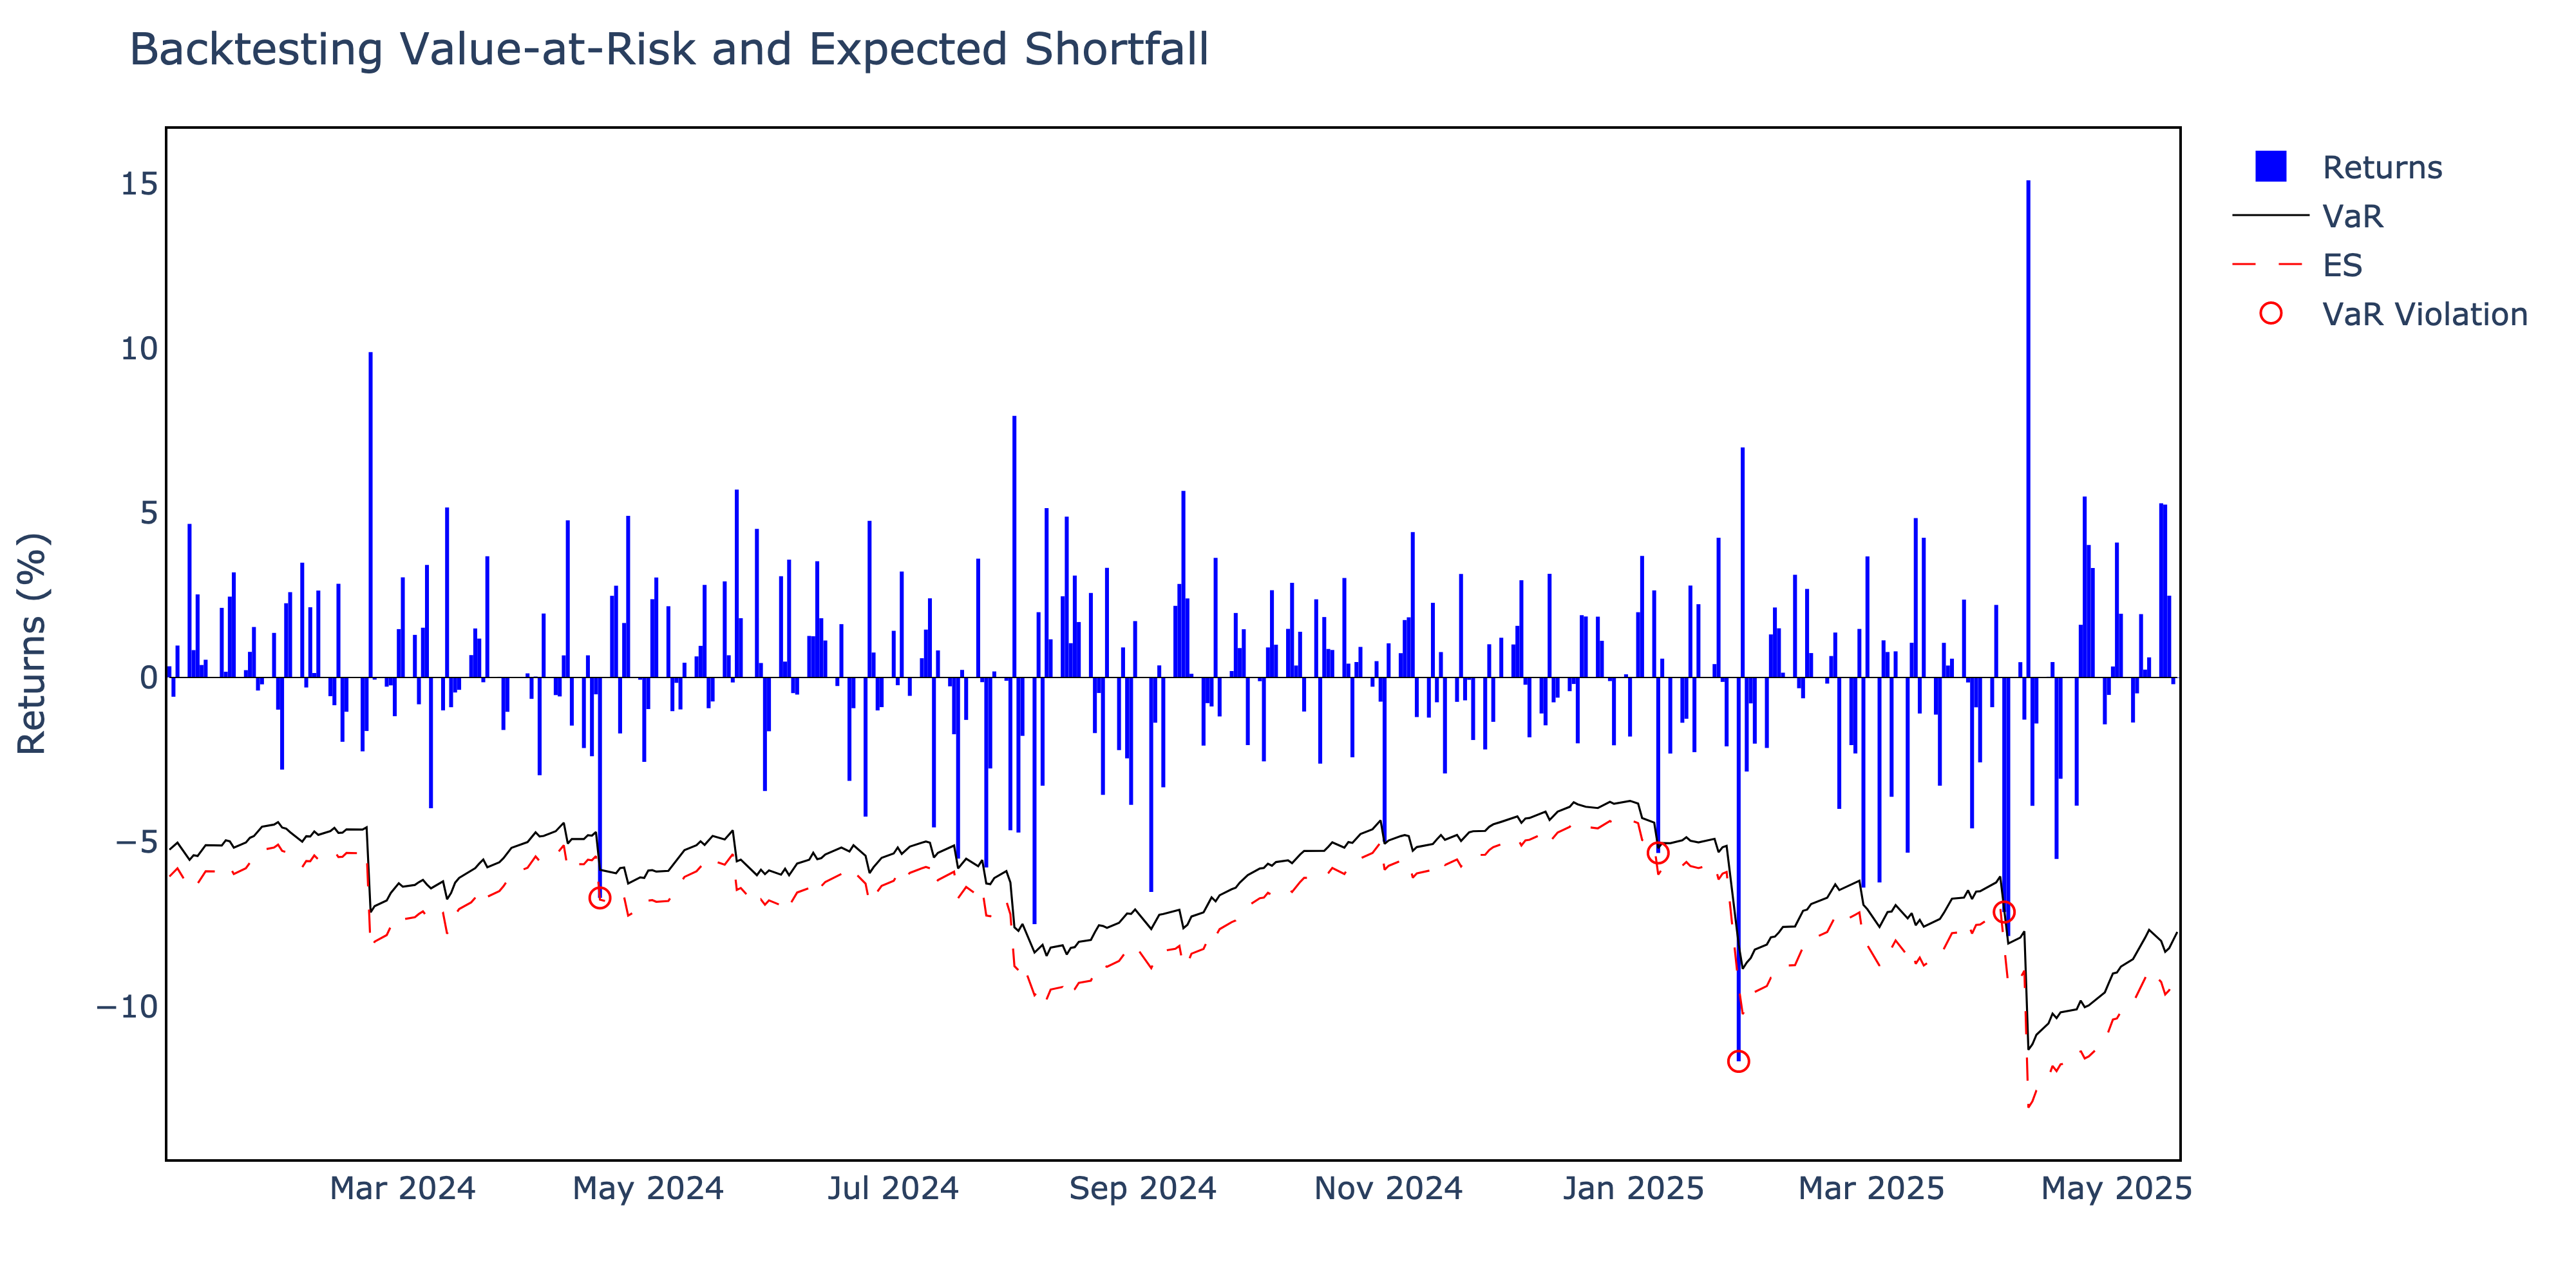

In [107]:
# Plot MA model results
fig_ma_es = IP.plot_backtest(result_ma, interactive=False)

# Plot RiskMetrics model results
fig_rm_es = IP.plot_backtest(result_rm, interactive=False)


In [108]:
violations_ma, rate_ma = BT.count_violations(result_ma)

print("== MA Correlation VaR Backtest ==")
print(f"Total Violations: {violations_ma}")
print(f"Violation Rate: {100*rate_ma:.2f}%")

== MA Correlation VaR Backtest ==
Total Violations: 4
Violation Rate: 1.23%


In [109]:
violations_rm, rate_rm = BT.count_violations(result_rm)

print("== RiskMetrics Correlation VaR Backtest ==")
print(f"Total Violations: {violations_rm}")
print(f"Violation Rate: {100*rate_rm:.2f}%")

== RiskMetrics Correlation VaR Backtest ==
Total Violations: 4
Violation Rate: 1.16%


In [110]:
fig_ma_vol = IP.plot_volatility(result_ma["Volatility"])
fig_rm_vol = IP.plot_volatility(result_rm["Volatility"])